<a href="https://colab.research.google.com/github/besherh/BigDataManagement/blob/main/SparkNotebooks/clusteranalysis_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setting up PySpark in Colab
Spark is written in the Scala programming language and requires the Java Virtual Machine (JVM) to run. Therefore, our first task is to download Java.



In [ ]:
!apt-get install openjdk-8-jdk-headless

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 30 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jre-headless amd64 8u282-b08-0ubuntu1~18.04 [28.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jdk-headless amd64 8u282-b08-0ubuntu1~18.04 [8,267 kB]
Fetched 36.5 MB in 3s (10.9 MB/s)
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading database

Next, we will install Apache Spark 3.0.1 with Hadoop 2.7 .


In [ ]:
!wget https://apache.mirrors.nublue.co.uk/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz


--2021-03-22 17:15:38--  https://apache.mirrors.nublue.co.uk/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
Resolving apache.mirrors.nublue.co.uk (apache.mirrors.nublue.co.uk)... 141.0.161.104, 2a01:61c0:1:10:141:0:161:104
Connecting to apache.mirrors.nublue.co.uk (apache.mirrors.nublue.co.uk)|141.0.161.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220488957 (210M) [application/octet-stream]
Saving to: ‘spark-3.0.2-bin-hadoop2.7.tgz’

spark-3.0.2-bin-had 100%[===================>] 210.27M  5.04MB/s    in 35s     

2021-03-22 17:16:14 (5.96 MB/s) - ‘spark-3.0.2-bin-hadoop2.7.tgz’ saved [220488957/220488957]



Now, we just need to unzip that folder.


In [ ]:
!tar xf spark-3.0.2-bin-hadoop2.7.tgz


There is one last thing that we need to install and that is the findspark library. It will locate Spark on the system and import it as a regular library.



In [ ]:
!pip install -q findspark


Now that we have installed all the necessary dependencies in Colab, it is time to set the environment path. This will enable us to run Pyspark in the Colab environment.


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"


We need to locate Spark in the system. For that, we import findspark and use the findspark.init() method.

In [ ]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.0.2-bin-hadoop2.7'

Now, we can import SparkSession from pyspark.sql and create a SparkSession, which is the entry point to Spark.

You can give a name to the session using appName() and add some configurations with config() if you wish.

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

Finally, print the SparkSession variable.

In [ ]:
spark


#optional
If you want to view the Spark UI, you would have to include a few more lines of code to create a public URL for the UI page.

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels

--2021-03-15 11:15:15--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.211.152.205, 52.21.175.83, 54.84.220.80, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.211.152.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  19.1MB/s    in 0.7s    

2021-03-15 11:15:16 (19.1 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
{"tunnels":[],"uri":"/api/tunnels"}


#Loading data into PySpark
We will use the read.csv module. The inferSchema parameter provided will enable Spark to automatically determine the data type for each column but it has to go over the data once. If you don’t want that to happen, then you can instead provide the schema explicitly in the schema parameter.


In [ ]:

# Utility functions for Spark Cluster Analysis Hands-On
#
#
from itertools import cycle, islice
from math import sqrt
from numpy import array
from pandas.plotting import parallel_coordinates
from pyspark.ml.clustering import KMeans as KM
from pyspark.mllib.linalg import DenseVector
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def computeCost(featuresAndPrediction, model):
    allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]
    arrayCollection   = featuresAndPrediction.rdd.map(array)

    def error(point, predictedCluster):
        center = allClusterCenters[predictedCluster]
        z      = point - center
        return sqrt((z*z).sum())
    
    return arrayCollection.map(lambda row: error(row[0], row[1])).reduce(lambda x, y: x + y)


def elbow(elbowset, clusters):
	wsseList = []	
	for k in clusters:
		print("Training for cluster size {} ".format(k))
		kmeans = KM(k = k, seed = 1)
		model = kmeans.fit(elbowset)
		transformed = model.transform(elbowset)
		featuresAndPrediction = transformed.select("features", "prediction")

		W = computeCost(featuresAndPrediction, model)
		print("......................WSSE = {} ".format(W))

		wsseList.append(W)
	return wsseList

def elbow_plot(wsseList, clusters):
	wsseDF = pd.DataFrame({'WSSE' : wsseList, 'k' : clusters })
	wsseDF.plot(y='WSSE', x='k', figsize=(15,10), grid=True, marker='o')

def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')

	# Zip with a column called 'prediction' (index)
	Z = [np.append(A, index) for index, A in enumerate(centers)]

	# Convert to pandas for plotting
	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P

def parallel_plot(data, P):
	my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(P)))
	plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
	parallel_coordinates(data, 'prediction', color = my_colors, marker='o')


In [ ]:
#first downlad the file from this url (r-click then save as) :
#https://mailbcuac.sharepoint.com/:u:/s/CMP7203-BigDataManagement_GRP/EQzfZhLMgkxNkClacJCqrrwBRPkVwiYJalp9JQtI5tBnSQ?e=ybKi7a
# after that you can upload it to the colab
df = spark.read.csv("/content/minute_weather.csv", header=True, inferSchema=True)

The first argument specifies the URL to the daily_weather.csv file, the second argument specifies the spark-csv format, the third argument says the first line in daily_weather.csv is the header, and the fourth argument says to infer the data types.

In [ ]:
df.count()

1587257

In [ ]:
filteredDF = df.filter((df.rowID % 10) == 0)
filteredDF.count()

158726

In [ ]:
filteredDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,158726,793625.0,458203.9375103623,0,1587250
hpwren_timestamp,158726,None,None,2011-09-10 00:00:49,2014-09-10 23:53:29
air_pressure,158726,916.830161410269,3.0517165528304218,905.0,929.5
air_temp,158726,61.8515891536367,11.83356921064173,31.64,99.5
avg_wind_direction,158680,162.15610032770354,95.27820101905971,0.0,359.0
avg_wind_speed,158680,2.7752148979077846,2.0576239697426213,0.0,31.9
max_wind_direction,158680,163.46214393748426,92.45213853838614,0.0,359.0
max_wind_speed,158680,3.400557726241582,2.4188016208098935,0.1,36.0
min_wind_direction,158680,166.77401688933702,97.44110914784639,0.0,359.0


In [ ]:
filteredDF.filter(filteredDF.rain_accumulation == 0.0).count() 

157812

In [ ]:
filteredDF.filter(filteredDF.rain_duration == 0.0).count() 

157237

In [ ]:
workingDF = filteredDF.drop('rain_accumulation').drop('rain_duration').drop('hpwren_timestamp')

In [ ]:
before = workingDF.count()
workingDF = workingDF.na.drop()
after = workingDF.count()
before - after

46

In [ ]:
workingDF.columns

['rowID',
 'air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'min_wind_direction',
 'min_wind_speed',
 'relative_humidity']

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
featuresUsed = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(workingDF)

In [ ]:
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

In [ ]:
scaledData = scaledData.select("features", "rowID")

elbowset = scaledData.filter((scaledData.rowID % 3) == 0).select("features")
elbowset.persist()

DataFrame[features: vector]

In [ ]:
clusters = range(2,31)

wsseList = elbow(elbowset, clusters)

Training for cluster size 2 
......................WSSE = 114993.73508526216 
Training for cluster size 3 
......................WSSE = 102466.31220353257 
Training for cluster size 4 
......................WSSE = 95151.50105820014 
Training for cluster size 5 
......................WSSE = 92076.32347113916 
Training for cluster size 6 
......................WSSE = 84759.76929146728 
Training for cluster size 7 
......................WSSE = 82689.08581108255 
Training for cluster size 8 
......................WSSE = 78897.42030240592 
Training for cluster size 9 
......................WSSE = 76048.71871742973 
Training for cluster size 10 
......................WSSE = 74359.22850986672 
Training for cluster size 11 
......................WSSE = 71334.69986795336 
Training for cluster size 12 
......................WSSE = 70102.20833343921 
Training for cluster size 13 
......................WSSE = 68751.17112036466 
Training for cluster size 14 
......................WSSE = 67481.78146

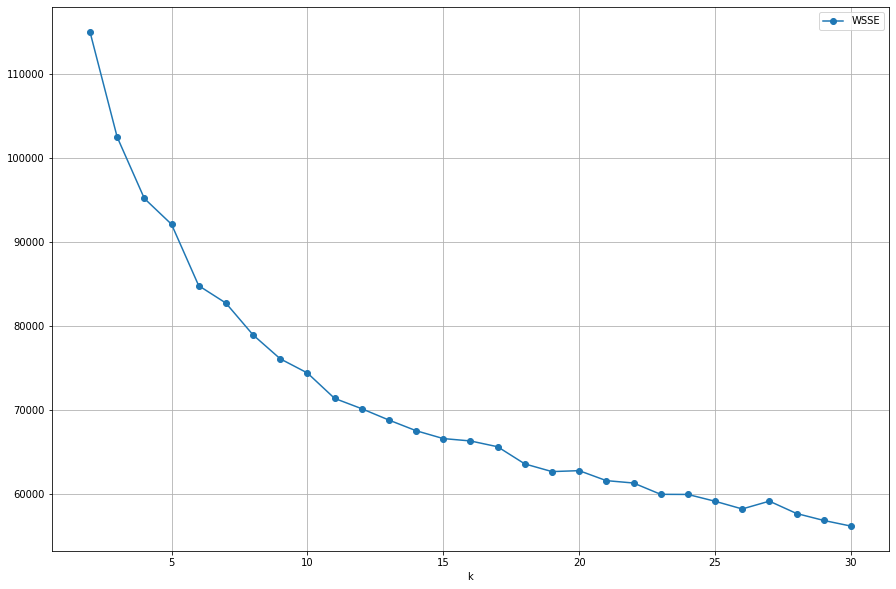

In [ ]:
elbow_plot(wsseList, clusters)

In [ ]:
scaledDataFeat = scaledData.select("features")
scaledDataFeat.persist()

DataFrame[features: vector]

In [ ]:
kmeans = KMeans(k=12, seed=1)
model = kmeans.fit(scaledDataFeat)
transformed = model.transform(scaledDataFeat)

In [ ]:
centers = model.clusterCenters()
centers

[array([-0.24087536,  0.89317498, -1.30906851, -0.57520841, -1.16974144,
        -0.59159648, -0.60687036]),
 array([ 0.30093585,  0.78641609,  1.31154052, -0.63097076,  1.57376747,
        -0.58240516, -0.75424234]),
 array([ 1.02863670e-03, -7.85281288e-01, -1.18366452e+00, -5.69017339e-01,
        -1.03073232e+00, -5.83853886e-01,  9.19797457e-01]),
 array([-0.87741375, -1.14844494,  0.37170793,  0.2393311 ,  0.47266284,
         0.22842591,  1.3456467 ]),
 array([ 1.2063516 , -0.34616575, -1.15622055,  2.67963877, -1.05958875,
         2.80546069, -1.14594124]),
 array([ 0.34667066, -0.96360578,  0.66675181, -0.54003592,  0.86118186,
        -0.52192382,  1.08559485]),
 array([-0.16974415,  0.61495037,  0.41023033,  0.6670633 ,  0.51934772,
         0.60869618, -0.18038098]),
 array([ 0.23478366,  0.32138349,  1.88791989, -0.65209959, -1.5511956 ,
        -0.5768484 , -0.28495592]),
 array([ 1.31481435, -0.07639869, -1.10903028, -0.47613978, -0.94738474,
        -0.47485927, -0.904

In [ ]:
P = pd_centers(featuresUsed, centers)

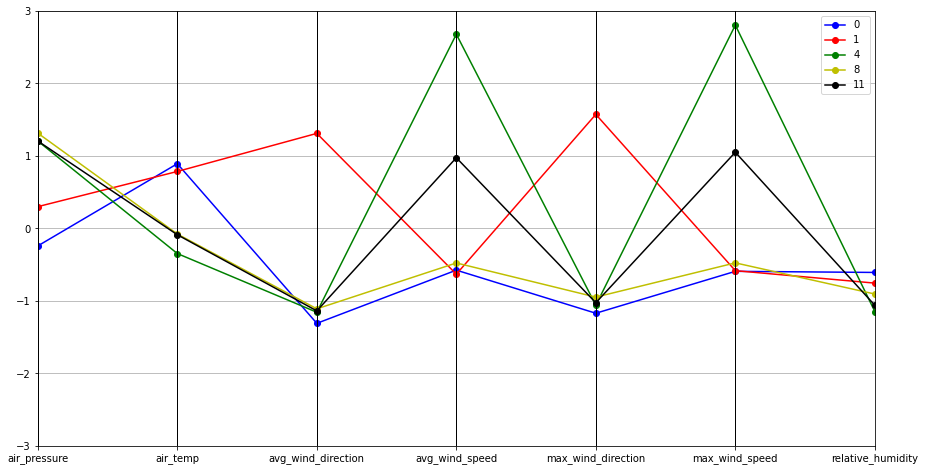

In [ ]:
# Dry Days
parallel_plot(P[P['relative_humidity'] < -0.5], P)

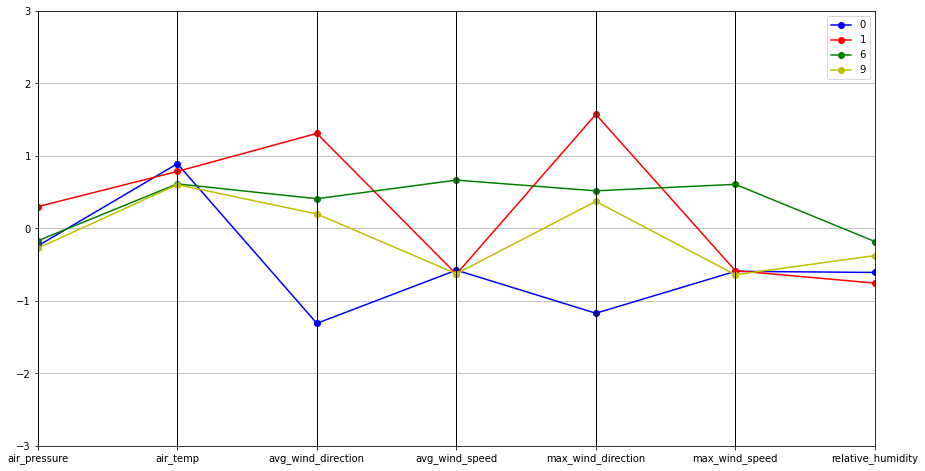

In [ ]:
#warm days
parallel_plot(P[P['air_temp'] > 0.5], P)

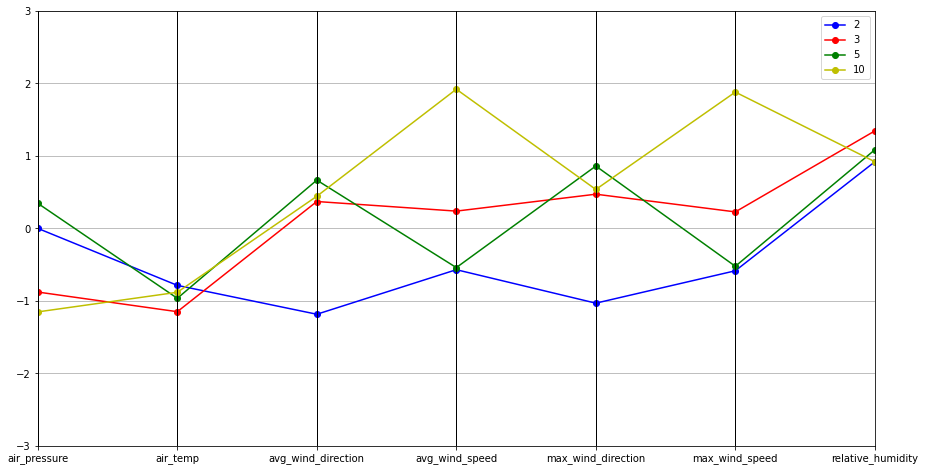

In [ ]:
#cool days
parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)], P)

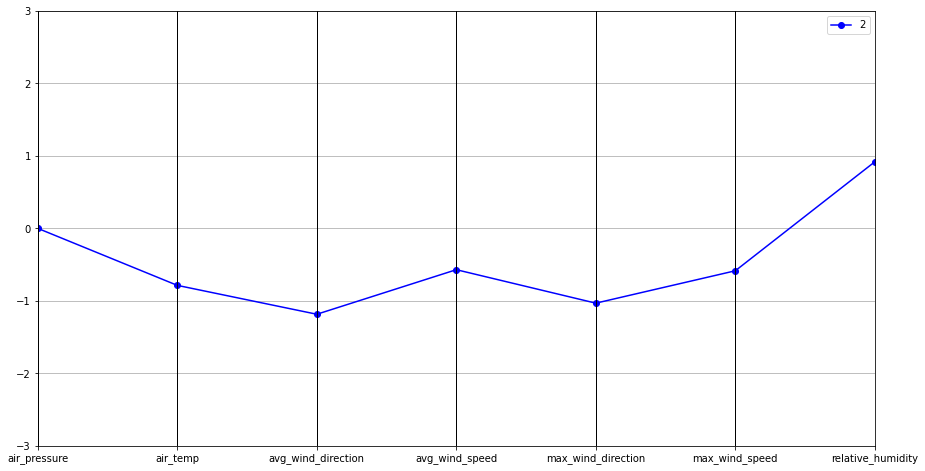

In [ ]:
#other days
parallel_plot(P.iloc[[2]], P)